Pre-processing of fire scar data using rasterio:
1. Ensure CRS match
2. Crop image to 512 by 512, centered on fire ignition point
3. Add edge padding filled with nan values for pixels outside bounds
4. Pull in all variables and reproject to same space as scar, save as bands
5. Save merged and mask images as .tif file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
import geopandas as gdp
from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from rasterio.windows import Window
from matplotlib.colors import Normalize

In [2]:
# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx") #excel meta-data file with file names and locations
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar available
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()

In [27]:
# Pick an example fire event

fire_id = 12 # look at first event
example_fire = df.loc[fire_id]

# Extract variables of interest for meta data

fire_season = example_fire["FireSeason"]
ign_date = example_fire["IgnitionDate_CONAF"]
control_date = example_fire["ControlDate_CONAF"]
ign_date = pd.to_datetime(ign_date)
fire_month = ign_date.strftime("%m")

prev_month = ign_date.month - 1
if prev_month == 0:
    prev_month = 12  # wrap around to December if January
prev_month = f"{prev_month:02d}"  # format as two-digit string

control_date = pd.to_datetime(control_date)
duration = control_date - ign_date + pd.Timedelta(days=1) # If controlled same day, duration is 1 day
latitude = example_fire["Latitude [°]"]
longitude = example_fire["Longitude [°]"]
ignition_point = (latitude, longitude)
magnitude = example_fire["Area_CONAF [ha]"] # Size of fire reported by conaf
spread_velocity = magnitude / duration.days # In hectares / day

# FOlders to data
folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
scar_folder = f"capas/incendio/FireScars"
severity_folder = f"capas/incendio/Severity"
file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }

#save paths to images
pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
fire_scar_vector_path = os.path.join(folder, example_fire["FireScarVectorName"])
fire_scar_path = os.path.join(scar_folder, example_fire["FireScarImgName"])
severity_path = os.path.join(severity_folder, example_fire["SeverityImgName"])

In [28]:
prev_month

'02'

In [4]:
example_fire

index                                                            22
FireID                                                     ID100119
FireSeason                                                     2003
RegionCode                                                    CL-ML
Region_CONAF                                                  Maule
FireName_CONAF                                             QUILIPIN
Area_CONAF [ha]                                               100.0
IgnitionDate_CONAF                                       2003-03-12
ControlDate_CONAF                                        2003-03-13
Latitude [°]                                               -35.7146
Longitude [°]                                              -71.6365
FireScar                                                          1
FolderLocation                            FireScar_CL-ML_Maule_2003
FireScarImgName           FireScar_CL-ML_ID100119_u350_20030312.tif
PreFireImgName             ImgPreF_CL-ML_ID10011

In [5]:
# Read fire scar shape file as geo data frame
fire_scar_vector = gdp.read_file(fire_scar_vector_path)
fire_scar_vector = fire_scar_vector.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

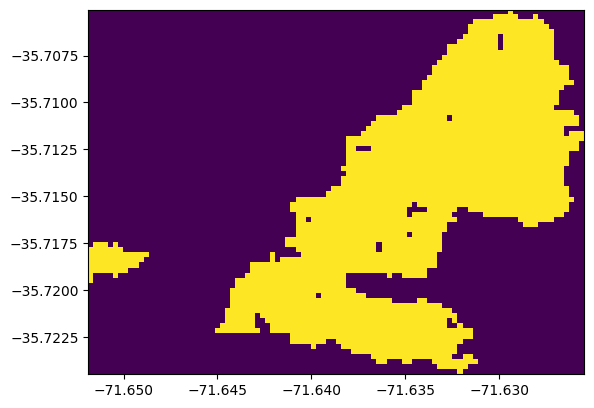

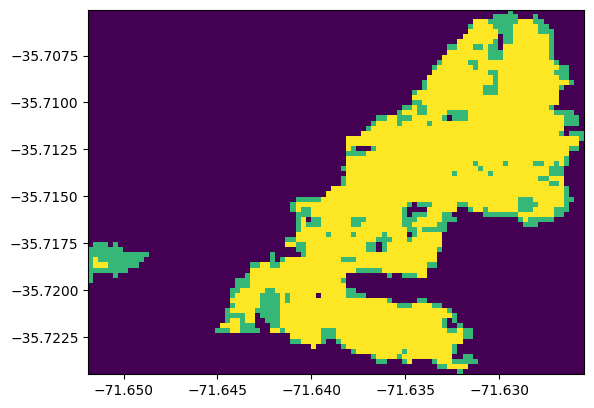

<Axes: >

In [6]:
fire_scar = rasterio.open(fire_scar_path)
severity = rasterio.open(severity_path)
show(fire_scar)
show(severity)

| 0.00, 0.00,-71.65|
| 0.00,-0.00,-35.71|
| 0.00, 0.00, 1.00|


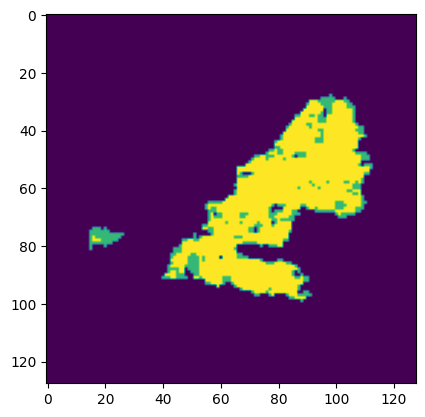

In [7]:
### Zero padding to ensure that the shape is 512 by 512
from rasterio.crs import CRS

# Open the original severity map
with rasterio.open(severity_path) as src:
    severity = src.read(1)
    h, w = severity.shape
    crs = src.crs
    transform = src.transform

# Target size
target_h, target_w = 128, 128

# Compute padding
pad_top = (target_h - h) // 2
pad_bottom = target_h - h - pad_top
pad_left = (target_w - w) // 2
pad_right = target_w - w - pad_left

# Pad with zeros (value=0)
padded_mask = np.pad(severity, 
                     ((pad_top, pad_bottom), (pad_left, pad_right)), 
                     mode='constant', constant_values=0)

# Calculate the shift in the top-left corner after padding
# Transform is (a, b, x, d, e, y), where (x, y) is the top-left corner of the image

# Shift in x direction (pad_left * pixel_size_x)
shift_x = np.float64(pad_left) * np.float64(transform[0])

# Shift in y direction (pad_top * pixel_size_y) - note that y is negative in many CRS
shift_y = np.float64(-pad_top) * np.float64(transform[4])

# Manually adjust the transform
new_transform = transform * rasterio.transform.Affine.translation(np.float64(shift_x), np.float64(shift_y))
print(new_transform)

# Show padded image
show(padded_mask)

# Save the padded image to disk with the adjusted transform
output_path = "padded_severity.tif"
with rasterio.open(output_path, 'w', driver='GTiff',
                   count=1, dtype=padded_mask.dtype,
                   crs=crs, transform=new_transform,
                   width=target_w, height=target_h) as dst:
    dst.write(padded_mask, 1)

In [8]:
transform

Affine(0.00026949458523585647, 0.0, -71.65187284958334,
       0.0, -0.00026949458523585647, -35.70506810331339)

In [52]:
with rasterio.open("padded_severity.tif") as padded_src:
    print("Padded mask CRS:", padded_src.crs)
    print("Padded mask transform:", padded_src.transform)
    
with rasterio.open(post_fire_path) as post_src:
    print("Post-fire image CRS:", post_src.crs)
    print("Post-fire image transform:", post_src.transform)

with rasterio.open(pre_fire_path) as post_src:
    print("Pre-fire image CRS:", post_src.crs)
    print("Pre-fire image transform:", post_src.transform)



Padded mask CRS: EPSG:4326
Padded mask transform: | 0.00, 0.00,-71.65|
| 0.00,-0.00,-35.71|
| 0.00, 0.00, 1.00|
Post-fire image CRS: EPSG:4326
Post-fire image transform: | 0.00, 0.00,-71.74|
| 0.00,-0.00,-35.63|
| 0.00, 0.00, 1.00|
Pre-fire image CRS: EPSG:4326
Pre-fire image transform: | 0.00, 0.00,-71.74|
| 0.00,-0.00,-35.63|
| 0.00, 0.00, 1.00|


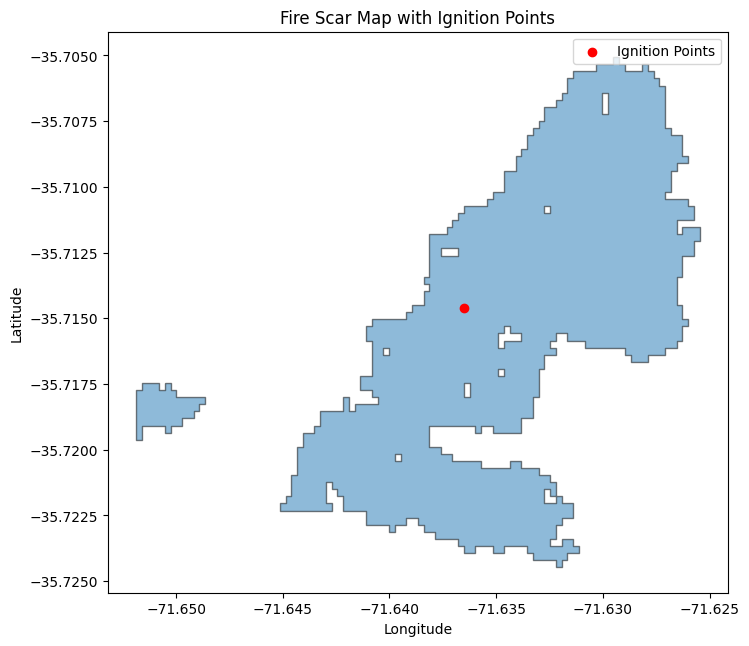

In [10]:
# Visualize fire scar with ignition point overlay

# Fire scar
ax = fire_scar_vector.plot(figsize=(8, 8), edgecolor="black", alpha=0.5)

# ignition point
plt.scatter(example_fire['Longitude [°]'],example_fire['Latitude [°]'], color='red', label='Ignition Points')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Fire Scar Map with Ignition Points")
plt.show()

## Visualizing some Layers for an example scar

In [29]:
# Setting paths for plotting

ignition_path = f"capas/incendio/ignition_probability_maps/ignition_prob_{fire_season}.tif"
dist_water_path = "capas/topografia/distance_to_water_ML.tif"
hl_path = "capas/topografia/heat_load_ML.tif"
tc_path = "capas/topografia/topo_complexity_ML.tif"
slope_path = "capas/topografia/slope_ML.tif"
elev_path = "capas/topografia/elevation_ML.tif"
aspect_path = "capas/topografia/aspect_ML.tif"
ndvi_path = f"capas/vegetacion/ndvi/MA_NDVI_{fire_season-1}.tif" # Previour Year (data leak)
fh_path = f"capas/incendio/fire_history_rasters_30yr/Maule_FireFreq_{fire_season}.tif" # Same Year
tslf_path = f"capas/incendio/time_since_last_fire/time_since_last_fire_{fire_season}.tif" # Same year
temp_anom_path = f"capas/clima/WorldClim_Maule/max_temp_anomaly/anomaly_wc2.1_2.5m_tmax_{fire_season}-{prev_month}.tif" # Previous month
min_temp_path = f"capas/clima/WorldClim_Maule/min_temp_anomaly/anomaly_wc2.1_2.5m_tmin_{fire_season}-{prev_month}.tif" # Previous month
precip_anom_path = f"capas/clima/WorldClim_Maule/precipitation_anomaly/anomaly_wc2.1_2.5m_prec_{fire_season}-{prev_month}.tif" # Previous month
sr_path = f"capas/clima/WorldClim_Maule/solar_radiation/wc2.1_30s_srad_{fire_month}.tif" # Month of fire
wvp_path = f"capas/clima/WorldClim_Maule/water_vapor_pressure/wc2.1_30s_vapr_{fire_month}.tif" #Month of fire
ws_path = f"capas/clima/WorldClim_Maule/wind_speed/wc2.1_30s_wind_{fire_month}.tif" #Month of fire
dist_road = "capas/antropico/distance_to_camino_ML.tif"
dist_pop = "capas/antropico/distance_to_populated_ML.tif"
pop_dens = "capas/antropico/pop_density_ML.tif"


In [31]:
fire_season-1


2002

In [32]:
control_date

Timestamp('2003-03-13 00:00:00')

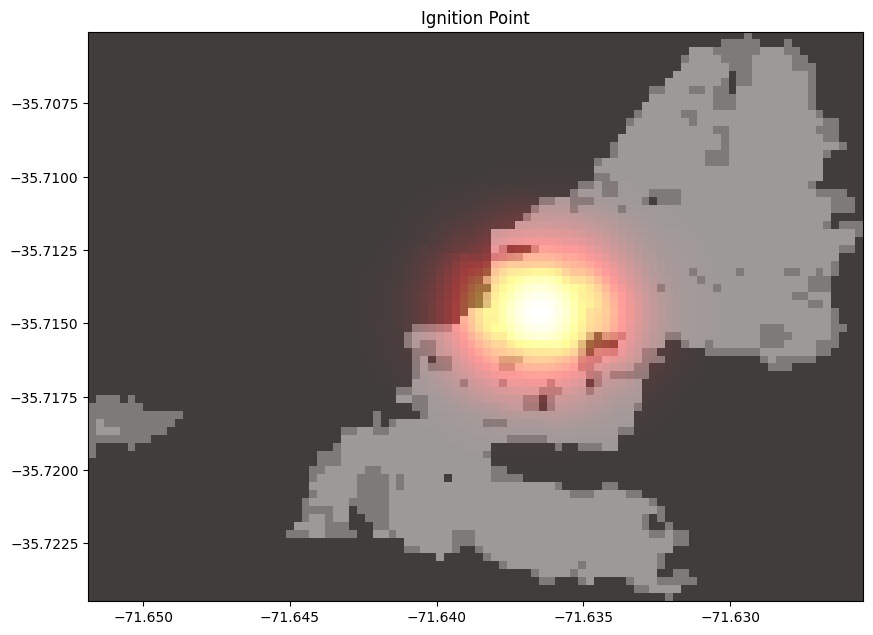

In [53]:
# Ignition Point
with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(ignition_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  # Or nearest, depending on your data
    )

# Now plot them using georeferenced `show`
fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
show(data2_reprojected, transform=transform1, ax=ax, cmap='hot', alpha=0.4)
ax.set_title("Ignition Point")
plt.show()

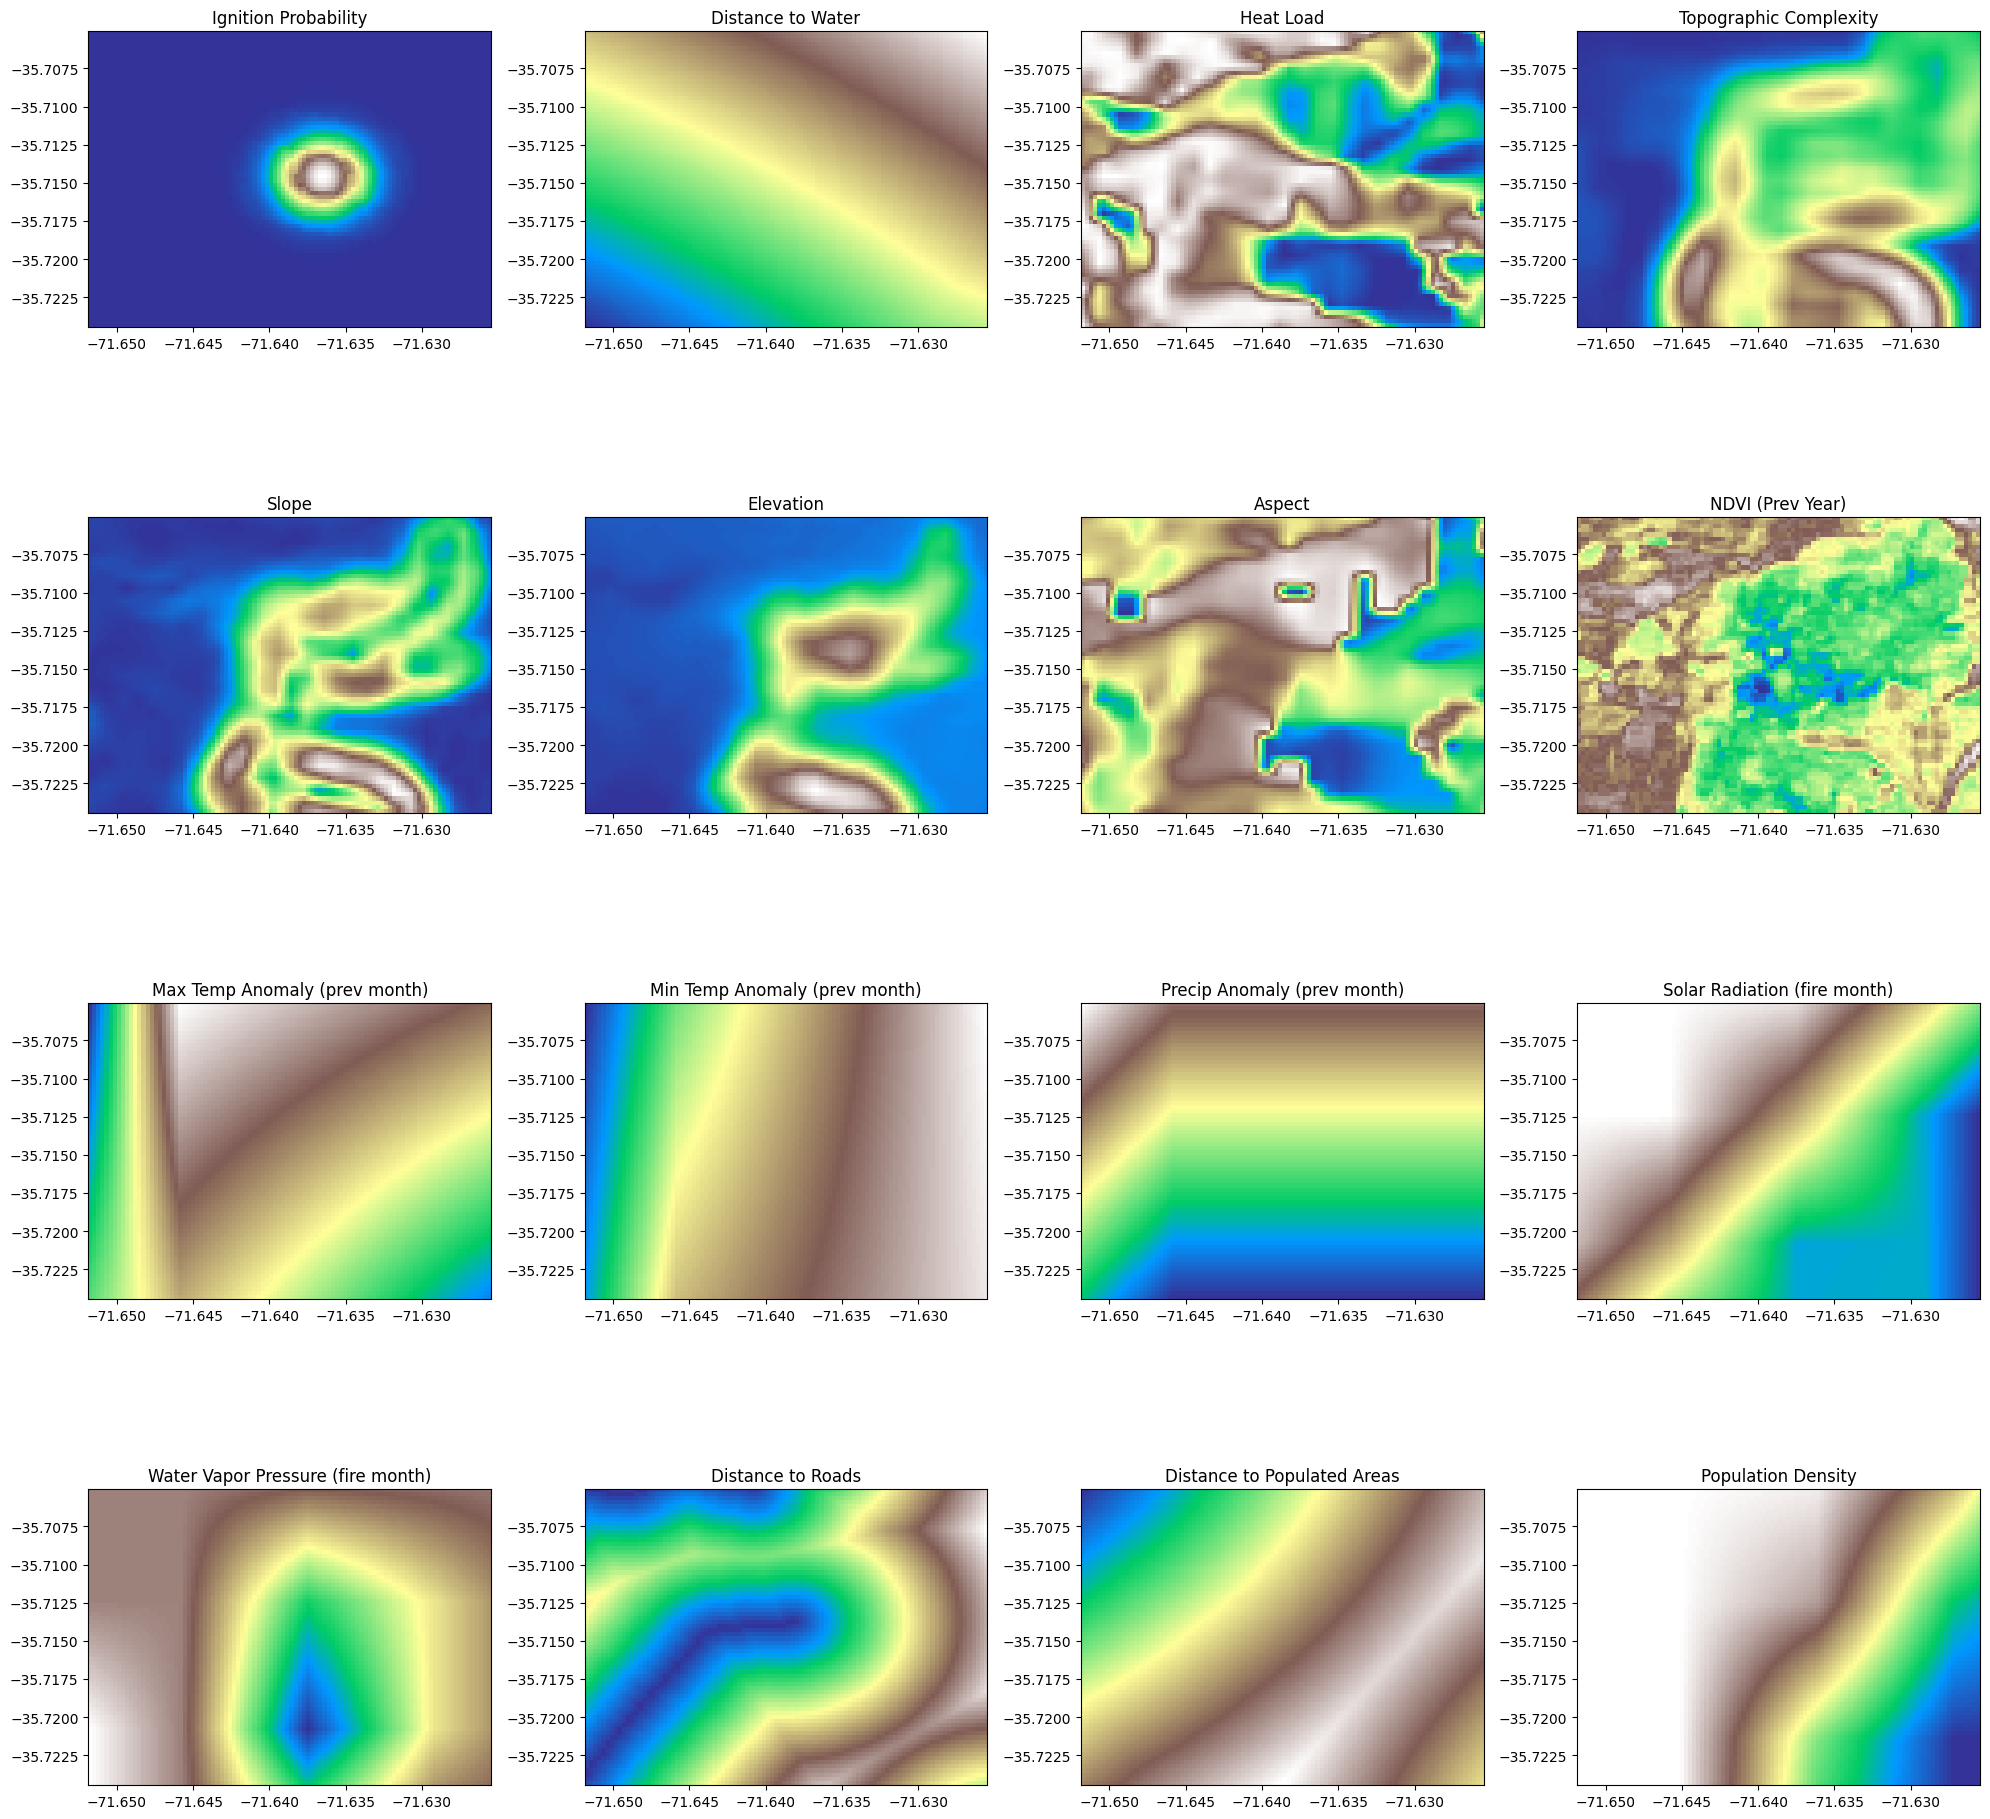

In [58]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os

# List of all raster paths and human-readable titles
raster_paths = {
    "Ignition Probability": ignition_path,
    "Distance to Water": dist_water_path,
    "Heat Load": hl_path,
    "Topographic Complexity": tc_path,
    "Slope": slope_path,
    "Elevation": elev_path,
    "Aspect": aspect_path,
    "NDVI (Prev Year)": ndvi_path,
    #"Fire History (30yr)": fh_path,
   # "Time Since Last Fire": tslf_path,
    "Max Temp Anomaly (prev month)": temp_anom_path,
    "Min Temp Anomaly (prev month)": min_temp_path,
    "Precip Anomaly (prev month)": precip_anom_path,
    "Solar Radiation (fire month)": sr_path,
    "Water Vapor Pressure (fire month)": wvp_path,
   # "Wind Speed (fire month)": ws_path,
    "Distance to Roads": dist_road,
    "Distance to Populated Areas": dist_pop,
    "Population Density": pop_dens,
}

# Read the base raster (severity) for reference CRS and shape
with rasterio.open(severity_path) as base_src:
    base_shape = (base_src.height, base_src.width)
    base_crs = base_src.crs
    base_transform = base_src.transform

# Prepare subplots
n = len(raster_paths)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# Loop through all rasters
for i, (title, path) in enumerate(raster_paths.items()):
    try:
        with rasterio.open(path) as src:
            data = src.read(1)

            # Handle CRS/transform differences by reprojecting
            if src.crs != base_crs or src.transform != base_transform:
                reprojected = np.empty(base_shape, dtype=np.float32)
                reproject(
                    source=data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=base_transform,
                    dst_crs=base_crs,
                    dst_shape=base_shape,
                    resampling=Resampling.bilinear
                )
                data = reprojected

            # Plot the raster
            show(data, transform=base_transform, ax=axes[i], cmap='viridis')
            axes[i].set_title(title)

    except Exception as e:
        print(f"Failed to load {title}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"{title}\n(Load Failed)")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


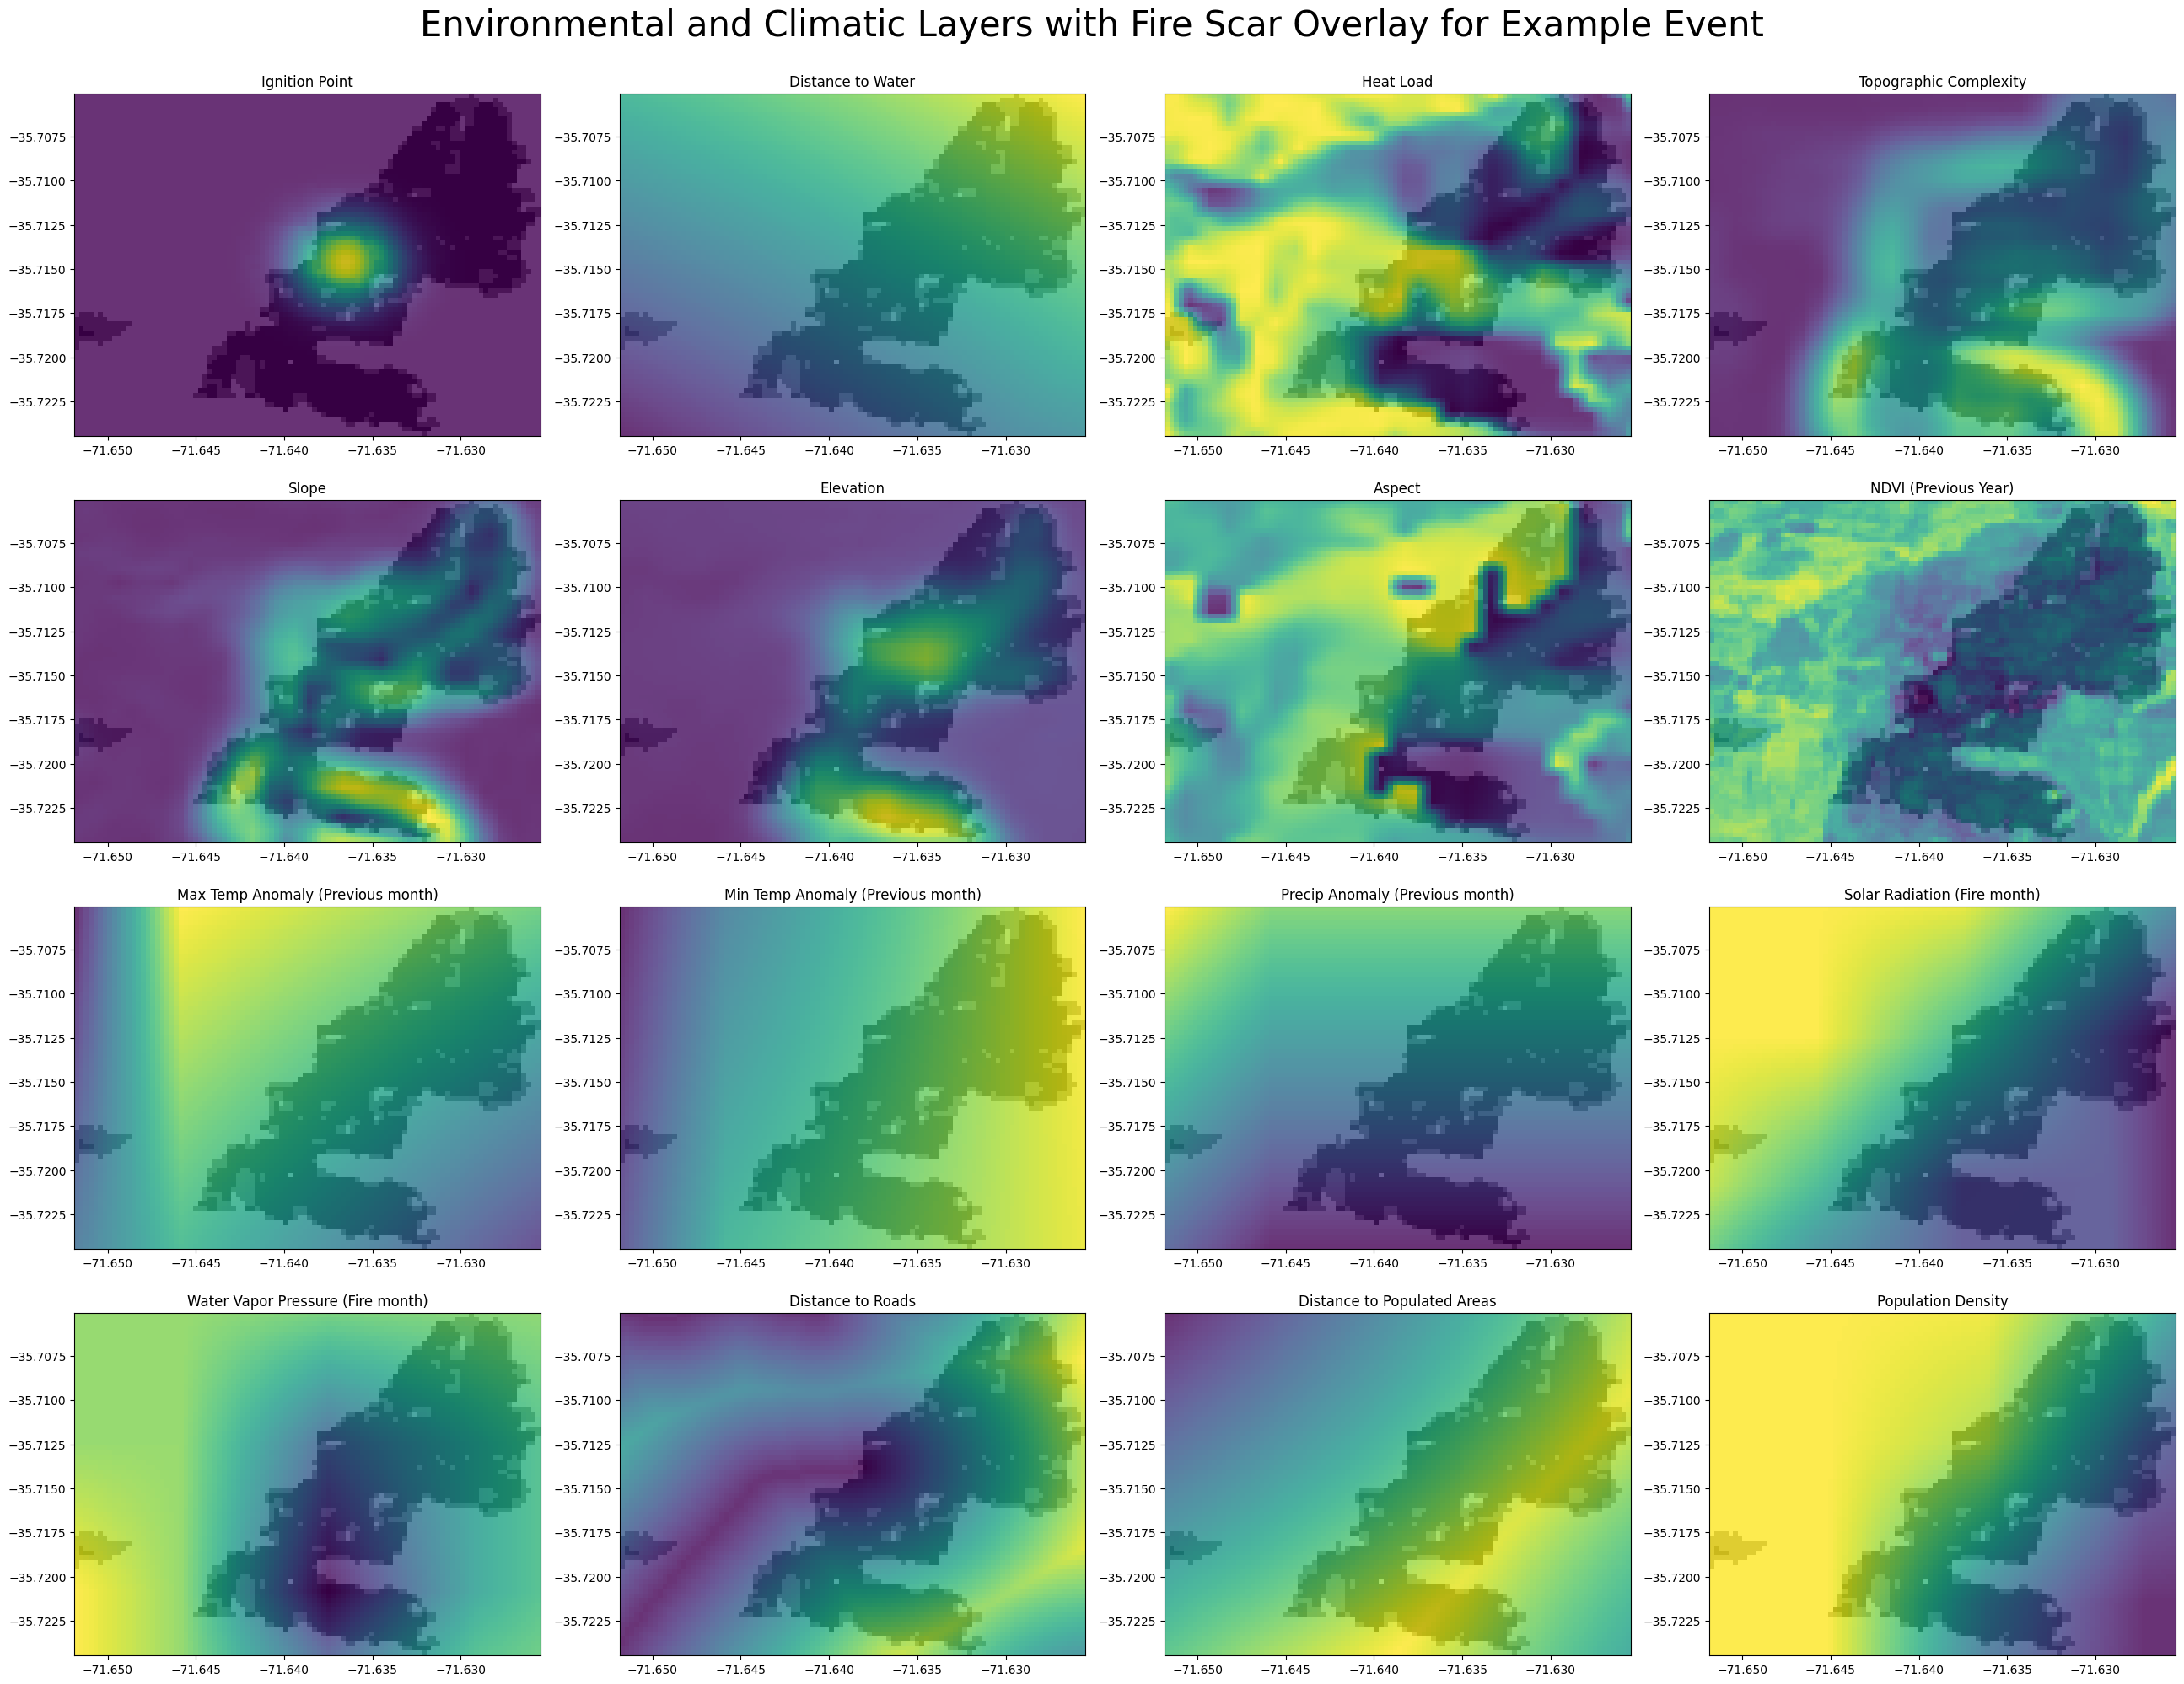

In [76]:
import rasterio
from mpl_toolkits.axes_grid1 import make_axes_locatable

from rasterio.warp import reproject, Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Load fire scar (severity raster) as base mask
with rasterio.open(severity_path) as src:
    fire_scar = src.read(1)
    base_crs = src.crs
    base_transform = src.transform
    base_shape = (src.height, src.width)

# List of rasters to overlay fire scar on
raster_paths = {
    "Ignition Point": ignition_path,
    "Distance to Water": dist_water_path,
    "Heat Load": hl_path,
    "Topographic Complexity": tc_path,
    "Slope": slope_path,
    "Elevation": elev_path,
    "Aspect": aspect_path,
    "NDVI (Previous Year)": ndvi_path,
   # "Fire History (30yr)": fh_path,
   # "Time Since Last Fire": tslf_path,
    "Max Temp Anomaly (Previous month)": temp_anom_path,
    "Min Temp Anomaly (Previous month)": min_temp_path,
    "Precip Anomaly (Previous month)": precip_anom_path,
    "Solar Radiation (Fire month)": sr_path,
    "Water Vapor Pressure (Fire month)": wvp_path,
   # "Wind Speed (fire month)": ws_path,
    "Distance to Roads": dist_road,
    "Distance to Populated Areas": dist_pop,
    "Population Density": pop_dens,
}

# Subplot setup
n = len(raster_paths)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(26, rows * 5))
axes = axes.flatten()

for i, (title, path) in enumerate(raster_paths.items()):
    try:
        with rasterio.open(path) as src:
            layer = src.read(1)

            # Reproject if needed
            if src.crs != base_crs or src.transform != base_transform:
                layer_reproj = np.empty(base_shape, dtype=np.float32)
                reproject(
                    source=layer,
                    destination=layer_reproj,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=base_transform,
                    dst_crs=base_crs,
                    dst_shape=base_shape,
                    resampling=Resampling.bilinear
                )
                layer = layer_reproj

            ax = axes[i]
            show(layer, transform=base_transform, ax=ax, cmap='viridis')
            # Overlay fire scar with alpha for transparency
            show(fire_scar, transform=base_transform, ax=ax, cmap='Greys', alpha=0.2)
            ax.set_title(title)

    except Exception as e:
        print(f"Failed to load {title}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"{title}\n(Load Failed)")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Environmental and Climatic Layers with Fire Scar Overlay for Example Event", fontsize=30, y=1)

plt.tight_layout()
plt.show()


## Topographic Variables

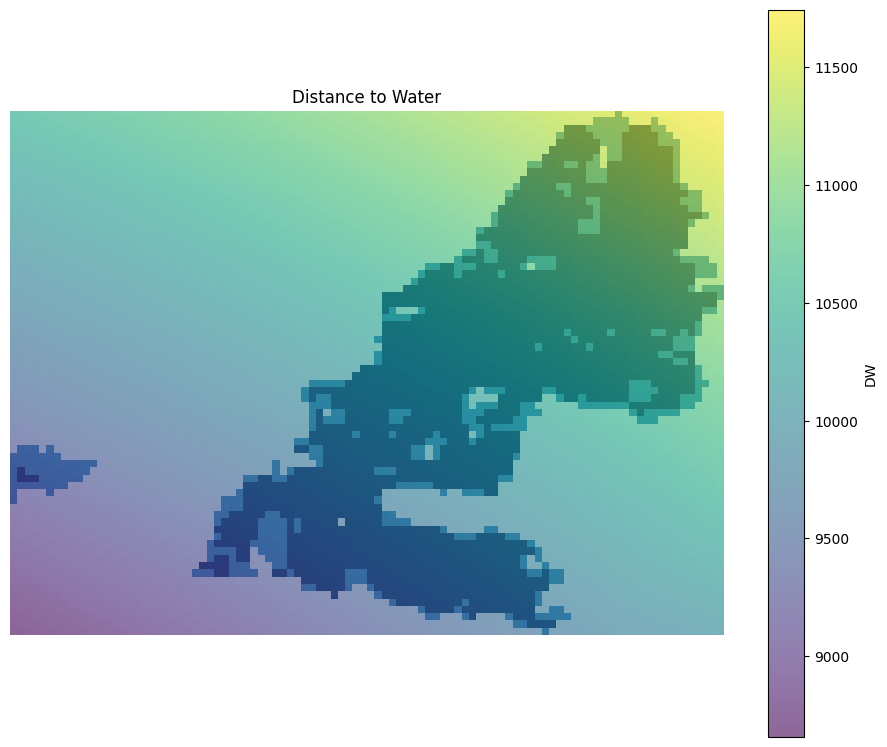

In [34]:
# Ignition Point
with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(dist_water_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  # Or nearest, depending on your data
    )

# Now plot them using georeferenced `show`
fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='Blues', alpha=1)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("DW")

ax.set_title("Distance to Water")
plt.tight_layout()
ax.axis('off')
plt.show()

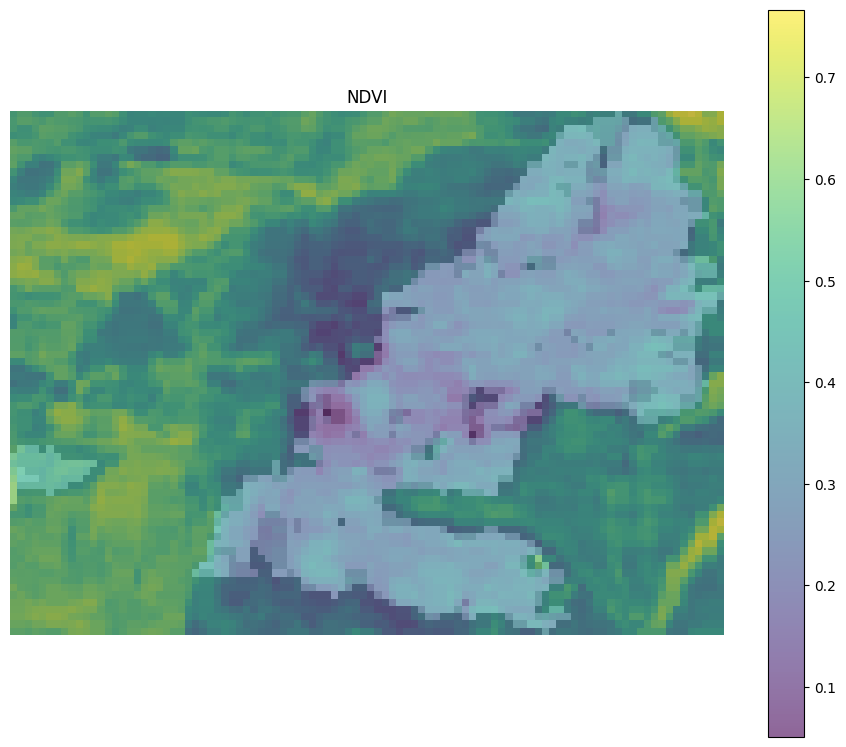

In [35]:
# Ignition Point
with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(ndvi_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  # Or nearest, depending on your data
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)


ax.set_title("NDVI")
plt.tight_layout()
ax.axis('off')
plt.show()

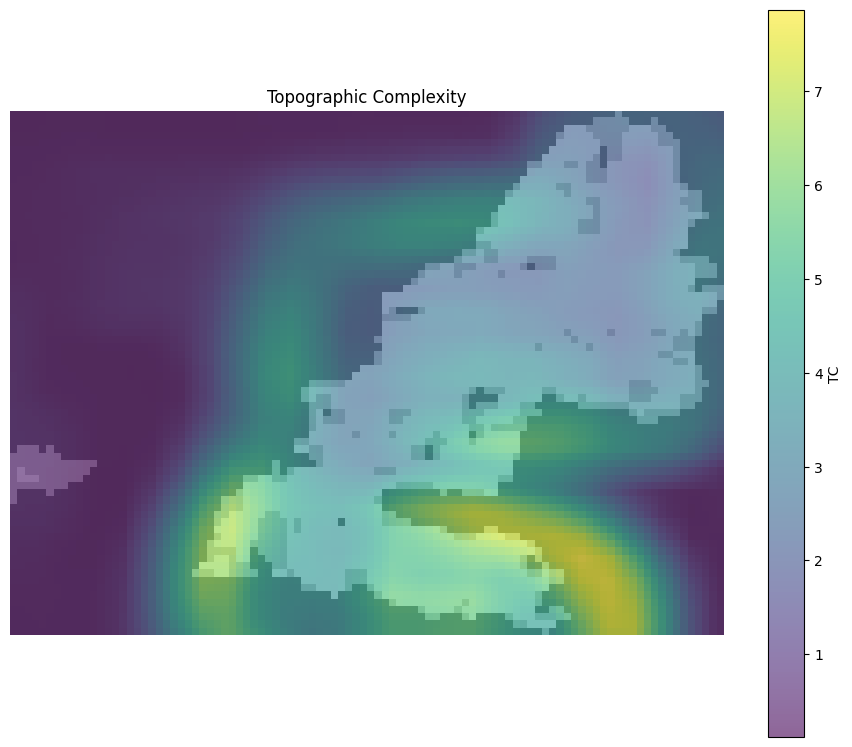

In [36]:

from matplotlib.colors import Normalize
with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(tc_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("TC")

ax.set_title("Topographic Complexity")
plt.tight_layout()
ax.axis('off')
plt.show()

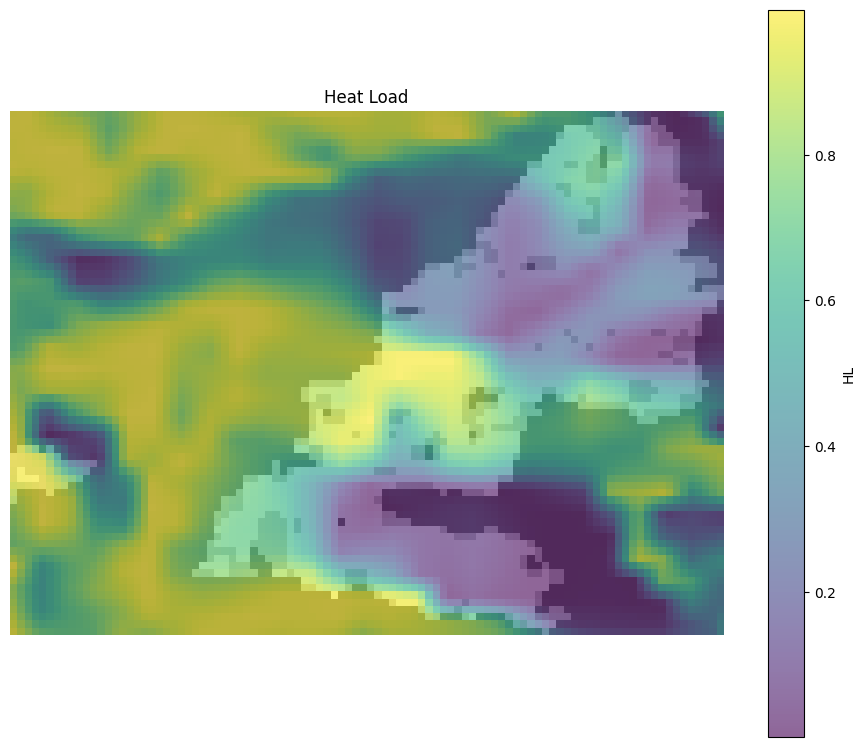

In [37]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(hl_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("HL")

ax.set_title("Heat Load")
plt.tight_layout()
ax.axis('off')
plt.show()

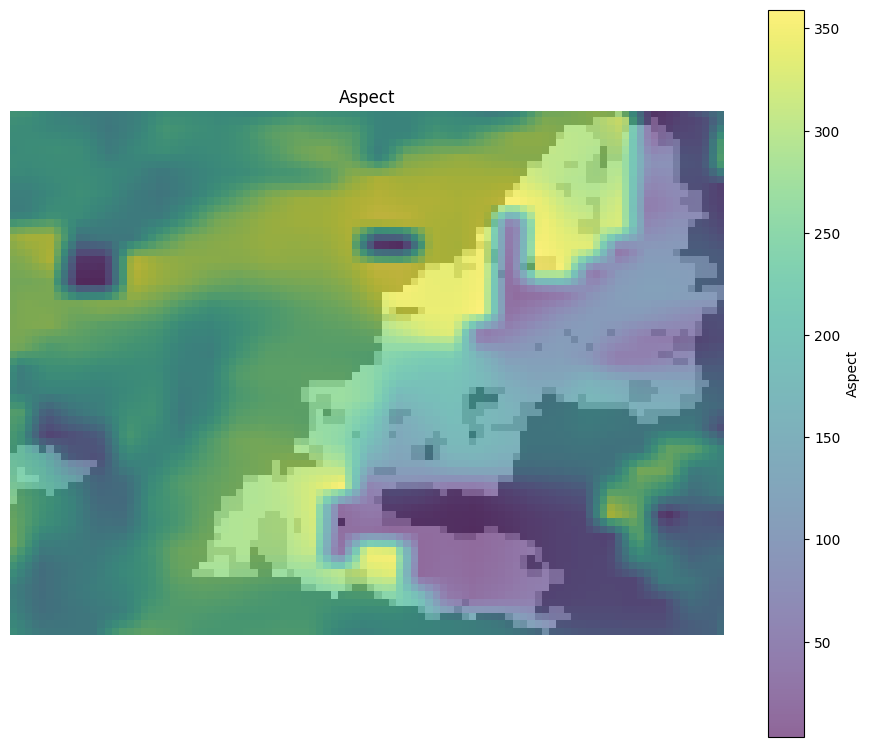

In [38]:

with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(aspect_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Aspect")

ax.set_title("Aspect")
plt.tight_layout()
ax.axis('off')
plt.show()

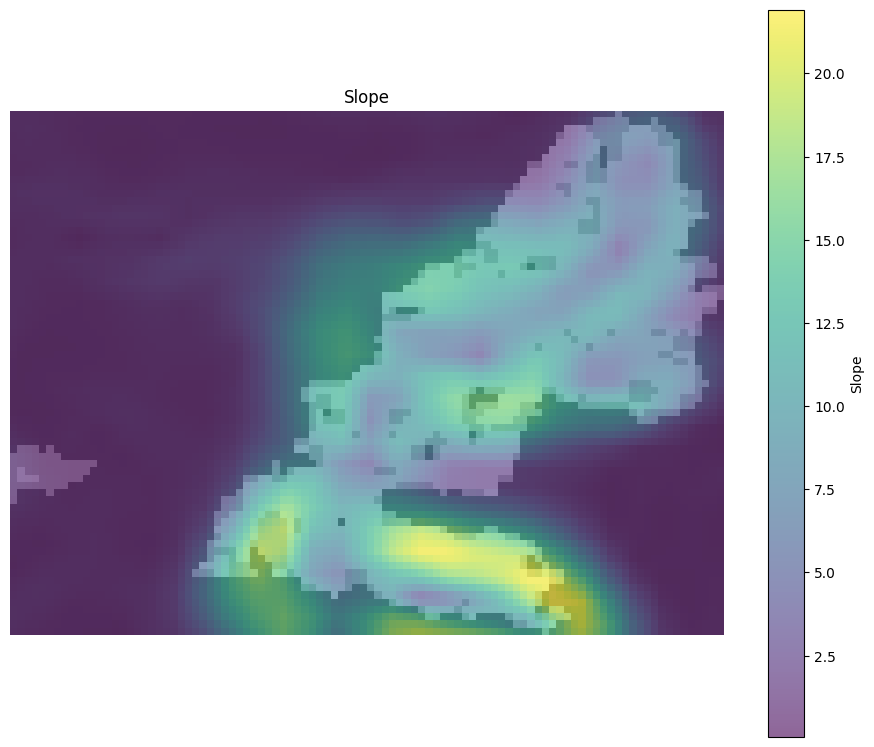

In [39]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(slope_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Slope")

ax.set_title("Slope")
plt.tight_layout()
ax.axis('off')
plt.show()

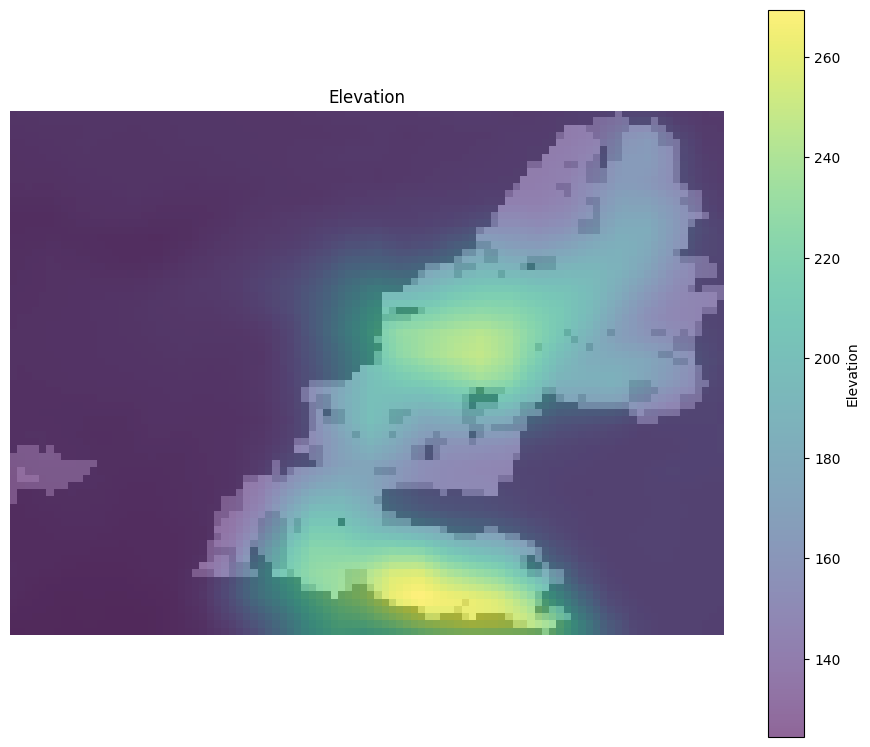

In [40]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(elev_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Elevation")

ax.set_title("Elevation")
plt.tight_layout()
ax.axis('off')
plt.show()

## Fire History Variables

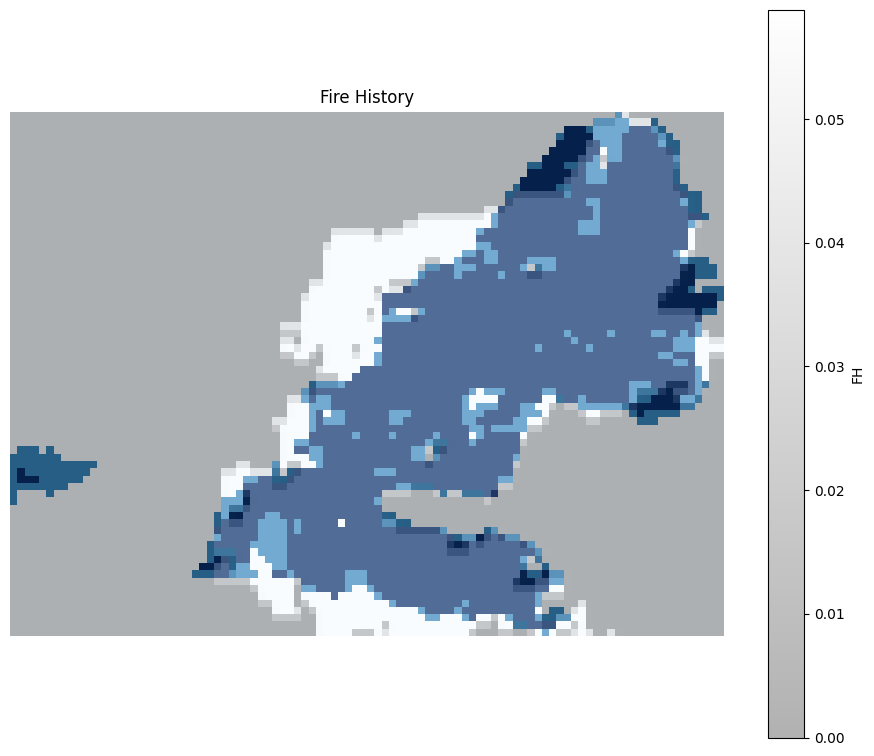

In [41]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(fh_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='Blues', alpha=1)
img = ax.imshow(data2_reprojected, 
                cmap='gray', 
                alpha=0.3, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("FH")

ax.set_title("Fire History")
plt.tight_layout()
ax.axis('off')
plt.show()

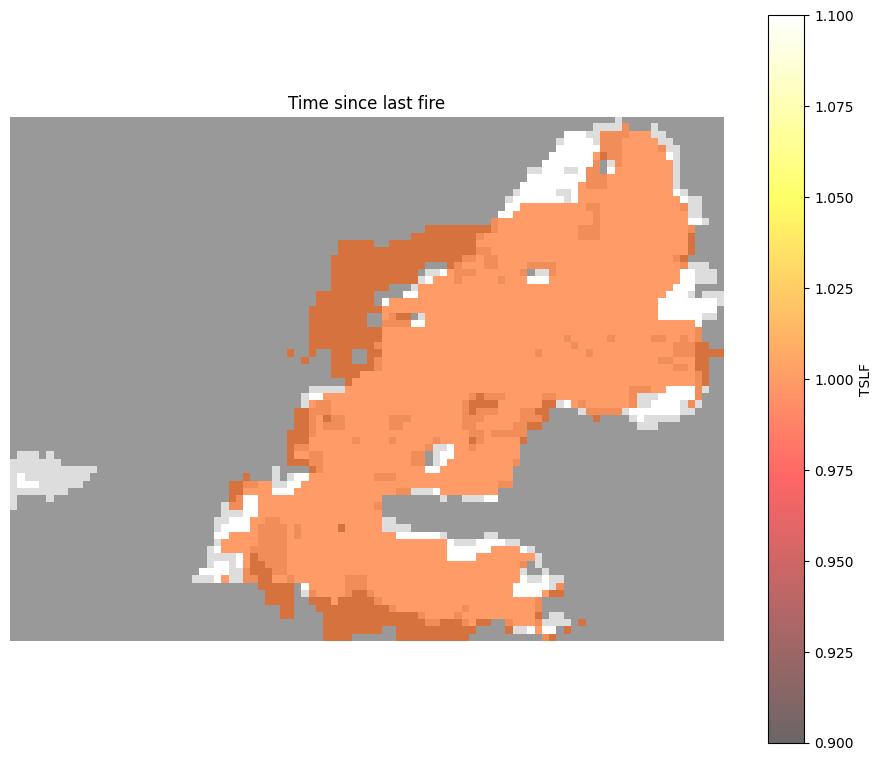

In [42]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(tslf_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=.4)
img = ax.imshow(data2_reprojected, 
                cmap='hot', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("TSLF")

ax.set_title("Time since last fire")
plt.tight_layout()
ax.axis('off')
plt.show()

## Climate Variables

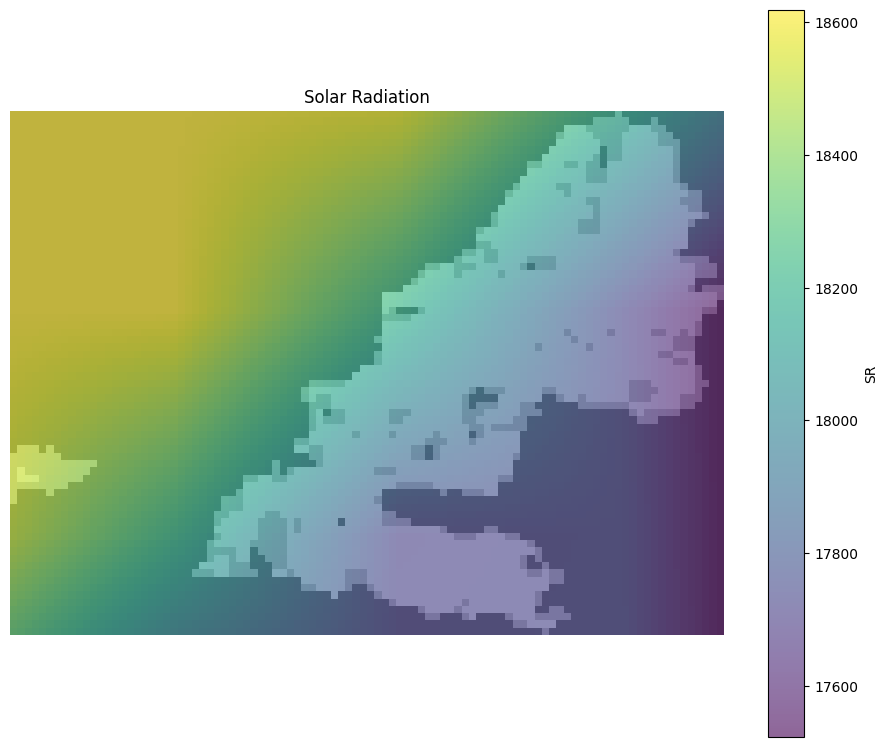

In [43]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(sr_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("SR")

ax.set_title("Solar Radiation")
plt.tight_layout()
ax.axis('off')
plt.show()

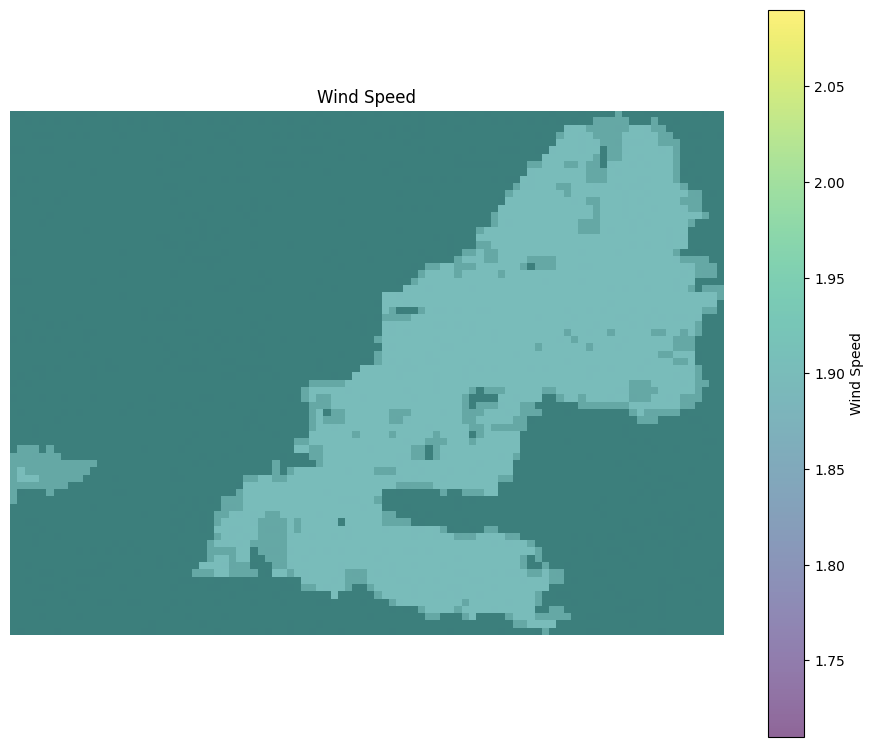

In [44]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(ws_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Wind Speed")

ax.set_title("Wind Speed")
plt.tight_layout()
ax.axis('off')
plt.show()

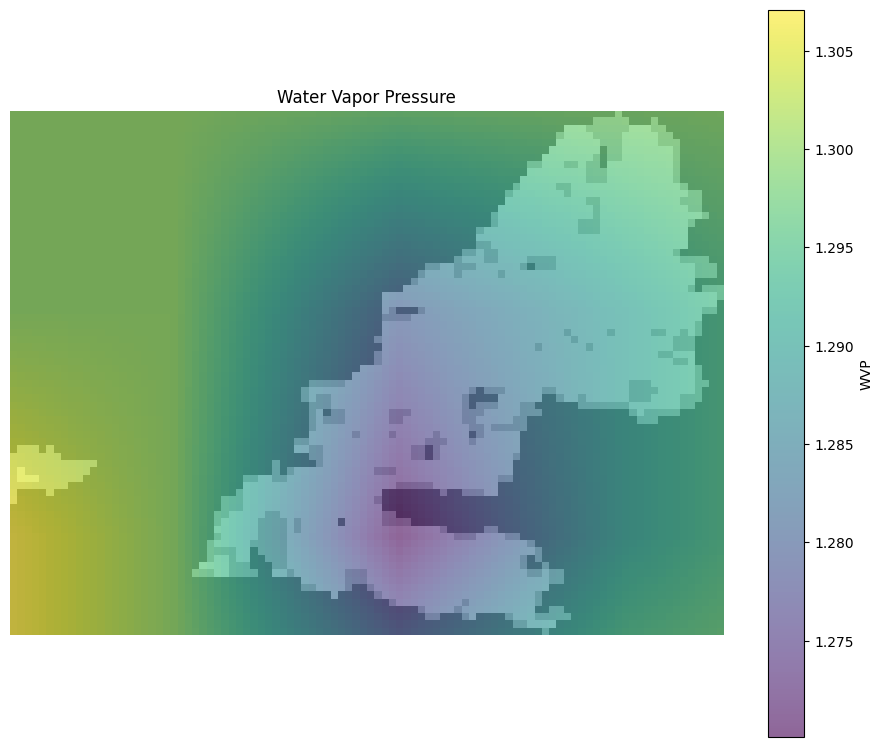

In [45]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(wvp_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("WVP")

ax.set_title("Water Vapor Pressure")
plt.tight_layout()
ax.axis('off')
plt.show()

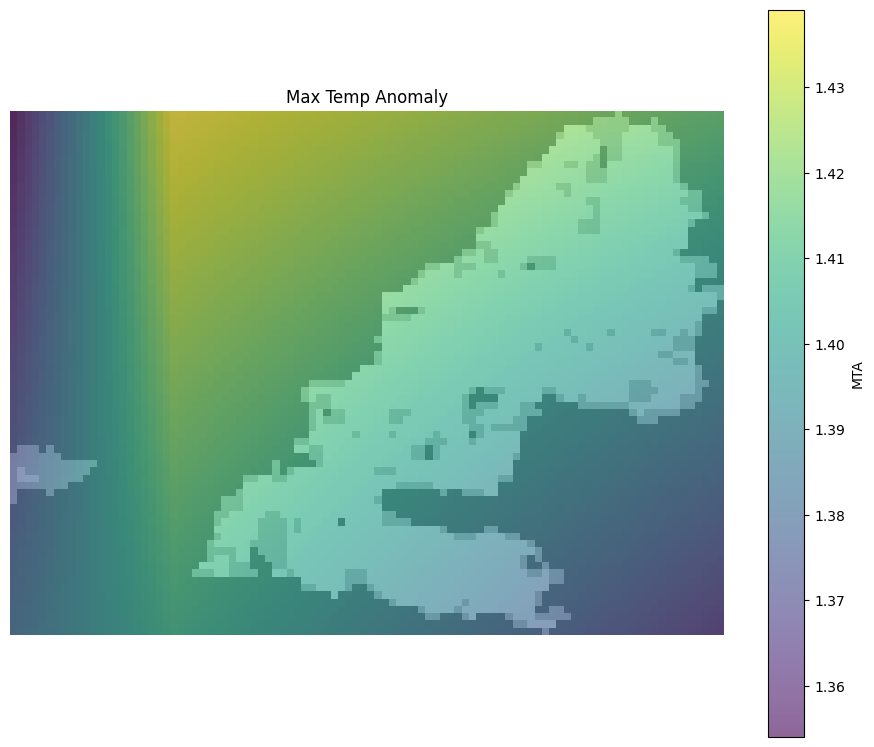

In [46]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(temp_anom_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("MTA")

ax.set_title("Max Temp Anomaly")
plt.tight_layout()
ax.axis('off')
plt.show()

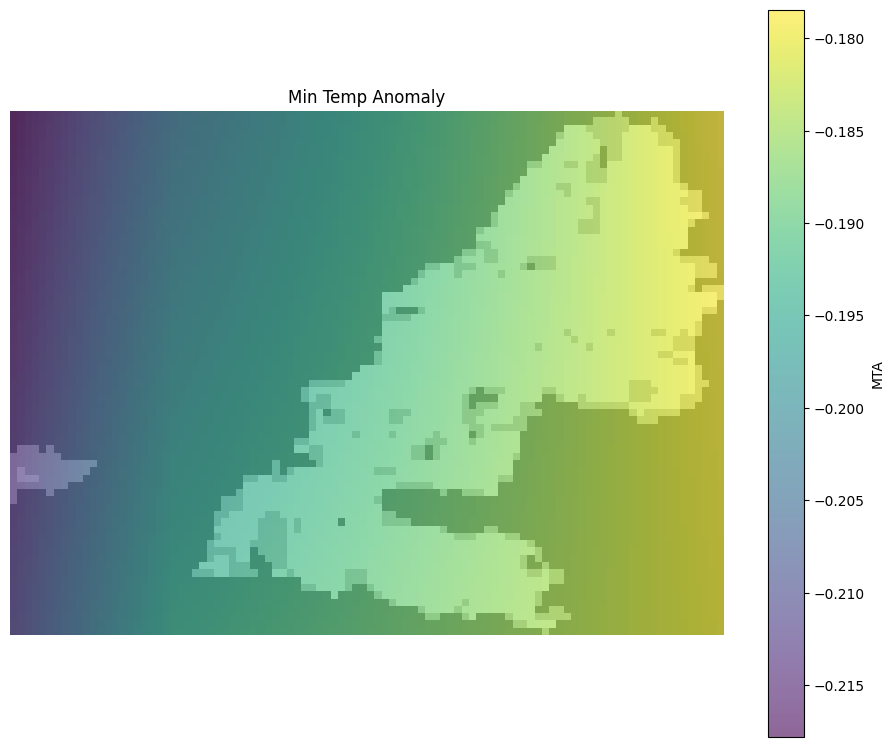

In [47]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(min_temp_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("MTA")

ax.set_title("Min Temp Anomaly")
plt.tight_layout()
ax.axis('off')
plt.show()

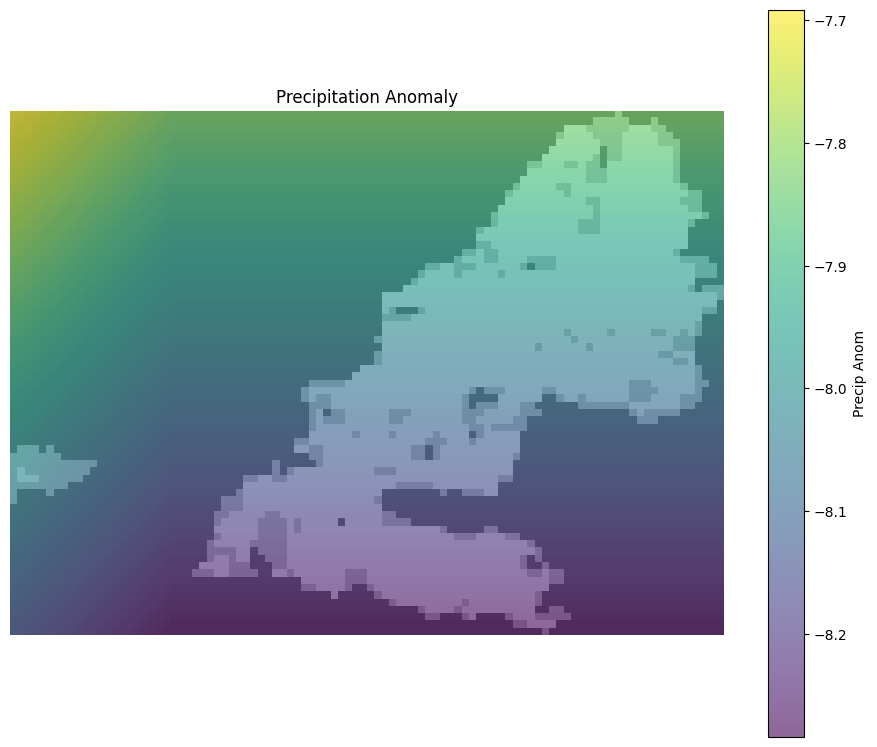

In [48]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(precip_anom_path) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Precip Anom")

ax.set_title("Precipitation Anomaly")
plt.tight_layout()
ax.axis('off')
plt.show()

## Anthro Variables



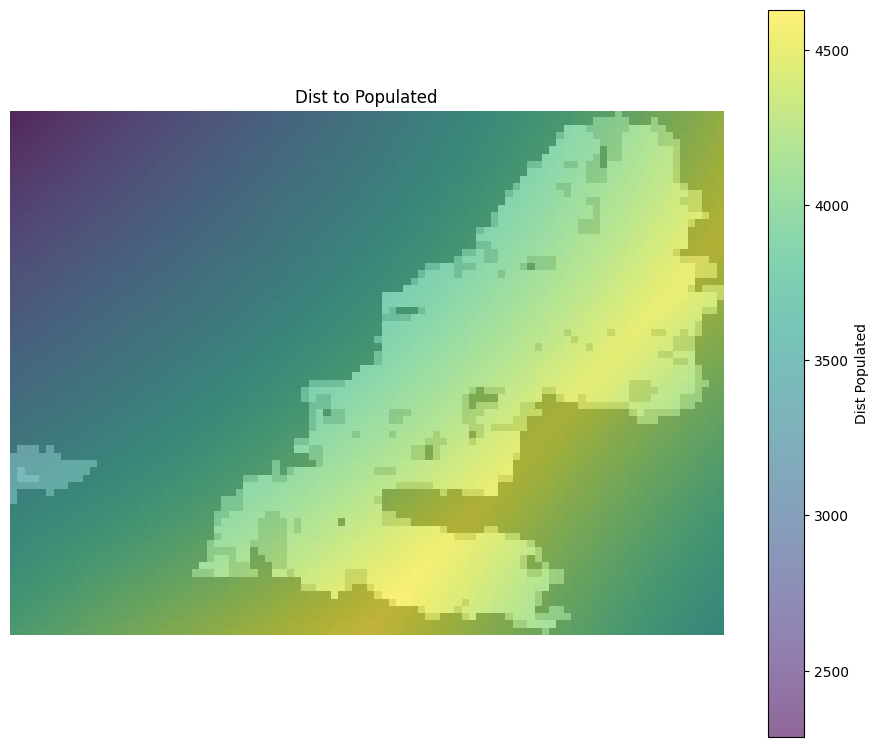

In [49]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(dist_pop) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Dist Populated")

ax.set_title("Dist to Populated")
plt.tight_layout()
ax.axis('off')
plt.show()

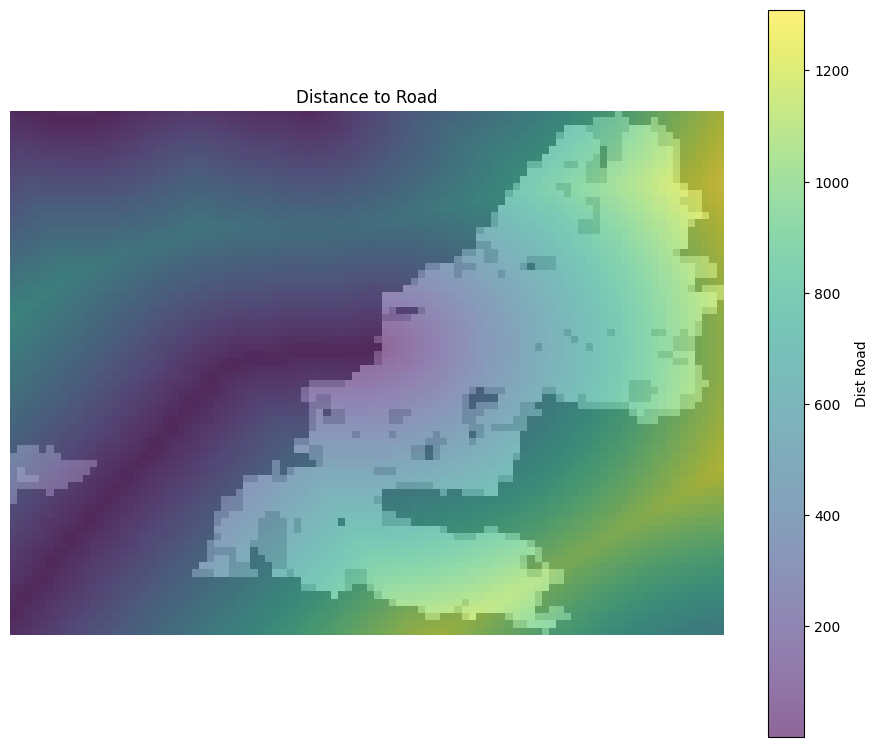

In [50]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(dist_road) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Dist Road")

ax.set_title("Distance to Road")
plt.tight_layout()
ax.axis('off')
plt.show()

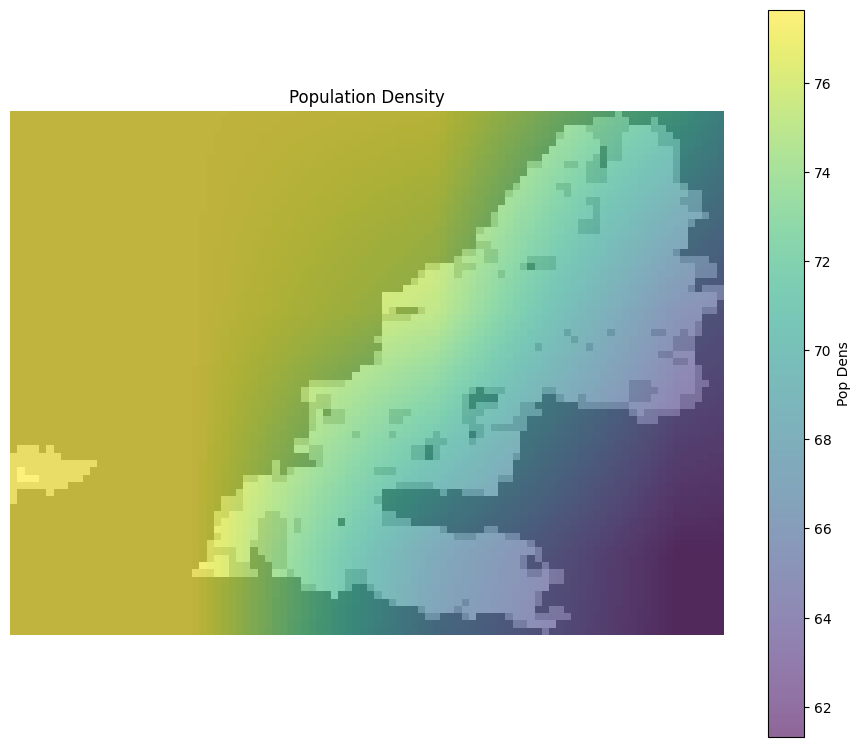

In [51]:


with rasterio.open(severity_path) as src1:
    data1 = src1.read(1)
    crs1 = src1.crs
    transform1 = src1.transform
    shape1 = (src1.height, src1.width)

with rasterio.open(pop_dens) as src2:
    data2_raw = src2.read(1)

    # Allocate output array matching raster1's shape
    data2_reprojected = np.empty(shape1, dtype=np.float64)

    reproject(
        source=data2_raw,
        destination=data2_reprojected,
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=transform1,
        dst_crs=crs1,
        dst_shape=shape1,
        resampling=Resampling.bilinear  
    )

fig, ax = plt.subplots(figsize=(10, 10))
show(data1, transform=transform1, ax=ax, cmap='gray', alpha=0.6)
img = ax.imshow(data2_reprojected, 
                cmap='viridis', 
                alpha=0.6, 
                transform=ax.transData, 
                extent=rasterio.plot.plotting_extent(data2_reprojected, transform=transform1),
                norm=Normalize(vmin=np.nanmin(data2_reprojected), vmax=np.nanmax(data2_reprojected)))


cbar = plt.colorbar(img, ax=ax, shrink=0.75)
cbar.set_label("Pop Dens")

ax.set_title("Population Density")
plt.tight_layout()
ax.axis('off')
plt.show()